In [6]:
from bs4 import BeautifulSoup

#build out the loop
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction import text as text
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [34]:
def upper_counter(x):
    count = 0
    for word in x.split():
        for letter in word:
            if letter.isupper():
                count += 1
    return count

## Load post data

In [7]:
datapath='/Users/lydiaelias/Desktop/Craigslist/'

clist2urls=np.loadtxt(datapath+'clist2urls.csv',delimiter=',',dtype='string') #the urls of all the posts
clist2ids=np.loadtxt(datapath+'clistids.csv',delimiter=',',dtype='string') #the post ids
clist2ids=[clist2ids[x][0].astype(int) for x in range(1,len(clist2ids))]
clist2labels=np.loadtxt(datapath+'clist2labels.csv',delimiter=',',dtype='string') #The labels (1=scam, 0=not scam)
clist2labels=np.array([clist2labels[x][0] or '-1' for x in range(1,len(clist2labels))])
clist2labels=clist2labels.astype(int)

#We have to correct a couple that were labeled after the data was taken and were since deleted
clist2labels[252]=0
clist2labels[265]=0
clist2labels[533]=0


## Scrape html and save it

Many links quickly expire or are deleted so it's important to save info

In [ ]:
postbodies=[]
for i in range(600): #These are very large datasets so we take the first 600
    response=get(clist2urls[i][0])
    html_soup = BeautifulSoup(response.text, 'html.parser')
    post = html_soup.find_all('section', class_= 'body')
    postbodies.append(post)
    
    postbodies=np.save('postbodies.npy') 

In [8]:
postbodies=np.load(datapath+'postbodies.npy')

## Extract info

getpostinfo is a function written specifically for parsing the html and extracting text of post, title, price, number of images, and location from postbodies

In [12]:
import os
os.chdir(datapath)
from getpostinfo import getpostinfo

bodytexts,titletexts,prices,nimgs,locs = getpostinfo(postbodies,clist2labels)

Besides the above, would like to extract info on whether the post contains the word "call" or "text" as well as how long the post is

In [13]:
contactlist=np.zeros(len(bodytexts))
bodycount=np.zeros(len(bodytexts))
txtinds=[x for x in range(len(bodytexts)) if bodytexts[x,1] not in np.array(['0','2','3'])] #getpostinfo uses 0 for a post without a body, 2 if it has been flagged, and 3 if it has been deleted 
bodytexts_clean=bodytexts[:,1][txtinds]

#Separate the words that are pushed together due to the start of a new line and clean
stop_words = stopwords.words('english')
for i in range(len(bodytexts_clean)):  
      
    #Separate words from end of previous line and start of new line by finding where an upper case is preceded by a lowercase    
    bodytexts_clean[i]="".join([c for c in bodytexts_clean[i] if c not in string.punctuation])
    uppers=np.array([np.char.isupper(x) for x in bodytexts_clean[i]])
    lowers=np.array([np.char.islower(x) for x in bodytexts_clean[i]])
    upinds=np.where(uppers==True)[0]
    badcaps=[x for x in upinds if x!=0 and lowers[x-1]==True]
    badcaps=badcaps[::-1]
    for j in badcaps:
        bodytexts_clean[i]=bodytexts_clean[i][:j] + ' ' + bodytexts_clean[i][j:]
        
    #Now continue with the cleaning
    bodytexts_clean[i]=bodytexts_clean[i].lower()
    tokenized = bodytexts_clean[i].split()
    tokenized = [item for item in tokenized if item not in stop_words]
    bodycount[txtinds[i]]=len(tokenized) #Count number of words in a post
    detokenized = " ".join(tokenized)
    bodytexts_clean[i] = detokenized
    if detokenized.find("call")>0 or detokenized.find("text")>0: #Find if 'call' or 'text' is in the post as usually scammers prefer email to phone
        contactlist[txtinds[i]]=1.

Find the number of uppercase letters in locations

In [35]:
upcount=[]
for i in range(len(locs)):
    locs[i,1]=locs[i,1].replace('(', '').replace(')', '') #Get rid of parentheses
    upcount.append(upper_counter(locs[i,1]))

## Clean and apply TFIDF to the title texts

In [15]:
txtinds=[x for x in range(len(titletexts)) if titletexts[x,1] not in np.array(['0','2','3'])]

train_texts=titletexts[:,1][txtinds]
train_labels=clist2labels[txtinds]

#Clean the text and remove english stopwords
stop_words = stopwords.words('english')
for i in range(len(train_texts)):
    train_texts[i]="".join([c for c in train_texts[i] if c not in string.punctuation])
    train_texts[i]=train_texts[i].lower()
    tokenized = train_texts[i].split()
    tokenized = [item for item in tokenized if item not in stop_words]
    detokenized = " ".join(tokenized)
    train_texts[i] = detokenized

tfidf_vectorizer = TfidfVectorizer()

train_vectors = tfidf_vectorizer.fit_transform(train_texts)

### Prepare data for random forest

In [37]:
#Now let's put it all in one big array. Columns will be prices, nimgs, contactlist, body word count, uppercase count, and index
feature_array=np.zeros((len(txtinds),6))
for i in range(len(txtinds)):
    feature_array[i][0]=prices[:,1][txtinds[i]]
    feature_array[i][1]=nimgs[:,1][txtinds[i]]
    feature_array[i][2]=contactlist[txtinds[i]]
    feature_array[i][3]=bodycount[txtinds[i]]
    feature_array[i][4]=upcount[txtinds[i]]
    feature_array[i][5]=i

### Split into a training and testing set

In [38]:
vec_train_rf,vec_test_rf,lab_train_rf,lab_test_rf=model_selection.train_test_split(feature_array,train_labels,test_size=0.4)

#Use the same indices for splitting the tfidf vectors
train_inds=vec_train_rf[:,5].astype(int)
test_inds=vec_test_rf[:,5].astype(int)

## Train the models

In [43]:
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(vec_train_rf[:,:5],lab_train_rf) #We cut the column with the indices off for training and testing
predlabs_rf = rf.predict_proba(vec_test_rf[:,:5])

model = MultinomialNB()
model.fit(train_vectors[train_inds], train_labels[train_inds])
predlabs_nb=model.predict_proba(train_vectors[test_inds])

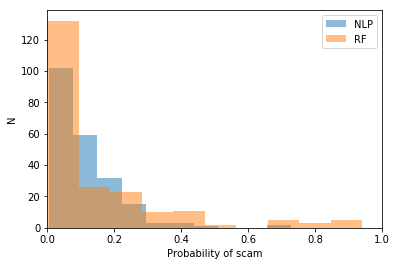

In [45]:
plt.figure()
plt.hist(predlabs_nb[:,1],alpha=0.5,label='NLP')
plt.hist(predlabs_rf[:,1],alpha=0.5,label='RF')
plt.xlim([0,1])
plt.legend()
plt.xlabel('Probability of scam')
plt.ylabel('N')

There's a good amount of overlap between the two populations, which is encouraging

## Decide on probability threshold for scam

Enforce that if either the probability from the rf OR from the nb models are above a certain threshold then it is a scam

In [55]:
#Let's try a threshold of 0.3
thresh=0.3
predlabs_binary=np.zeros(len(predlabs_rf))
spamind_rf=(predlabs_rf[:,1]>thresh)
spamind_nb=(predlabs_nb[:,1]>thresh)
predlabs_binary[spamind_rf]=1
predlabs_binary[spamind_nb]=1
tn, fp, fn, tp =confusion_matrix(lab_test_rf,predlabs_binary).ravel()
print [tn, fp, fn, tp]

[168, 16, 16, 17]


We correctly identify approximately half of scam listings, while only losing <10% of real listings as false positives

### AUC-ROC curve

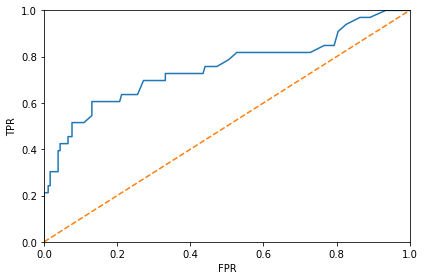

In [50]:
#AUC ROC plot
tprs=[]
fprs=[]
for thresh in np.linspace(0,1,200):
    predlabs_binary=np.zeros(len(predlabs_rf))
    spamind_rf=(predlabs_rf[:,1]>thresh)
    spamind_nb=(predlabs_nb[:,1]>thresh)
    predlabs_binary[spamind_rf]=1
    predlabs_binary[spamind_nb]=1
    tn, fp, fn, tp =confusion_matrix(lab_test_rf,predlabs_binary).ravel()

    tpr=np.float(tp)/(tp+fn)
    fpr=np.float(fp)/(tn+fp)
    tprs.append(tpr)
    fprs.append(fpr)
    
plt.figure()
plt.plot(fprs,tprs)
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0,1])
plt.ylim([0,1])
plt.tight_layout()
plt.show()